### Actors and actresses in the most profitable movies

This is a subplot with two plots. The first shows actors and the second shows actresses. 


I looked at each table to make note of all available columns. I noticed the tconst and nconst columns that I counld use to merge all of the data together into one dataframe. After merging, I dropped many columns that I did not need. These included columns that I though contained duplicate information or information that would not be useful. Next, I dropped rows with null values in a subset of all columns. I used outer merges so there where lots of rows with missing data. I wanted to be sure of the data that I had before getting rid of any. I also did not want to drop rows that were only missing data in either domestic or worldwide gross because I only needed one.

I then got just the rows where the profession was either actor or actress and made them their own dataframes. Then, I grouped them by the name of the person and summed the profits of all the movies they were in. Next, I sorted the people by the profit and selected the top 10. After that, I just plotted the top actors and actresses in the most profitable movies.



In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import time

In [2]:
#load data
nb = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
takas = pd.read_csv('data/zippedData/imdb.title.akas.csv.gz')
tbase = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
tbase = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
tcrew = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
tprinc = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
trat = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
tn = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

In [12]:

#rename takas['title_id'] to takas['tconst'] to that we can use it to merge on
takas.rename(columns={'title_id':'tconst'},inplace=True)
#merge data
tcombo = trat.merge(tcrew,how='outer',on='tconst')
tcombo = tcombo.merge(tbase,how='outer',on='tconst')
tcombo = tcombo.merge(takas,how='outer',on='tconst')
tcombo = tcombo.merge(tprinc,how='outer',on='tconst')
tcombo = tcombo.merge(nb,how='outer',on='nconst')

#change tcombo['primary_title'] to movie
tcombo.rename(columns={'primary_title':'movie'},inplace=True)
#finish merging
tcombo = tcombo.merge(tn,how='outer',on='movie')
#drop some columns
tcombo.drop(['language','types','attributes','is_original_title','ordering_x','ordering_y','original_title','numvotes','birth_year','death_year'],axis=1,inplace=True)
#drop null values from this subset of columns
tcombo.dropna(subset=['tconst','averagerating','directors','writers','movie','start_year','runtime_minutes','genres','title','region','id','release_date','production_budget'],inplace=True)

#I had lots of duplicates so I dropped the dupes in tconst and movie columns
tcombo.drop_duplicates(subset=['tconst','movie'],inplace=True)

#change budget and gross types to int
tcombo['production_budget'] = tcombo['production_budget'].map(lambda x: x.replace('$',""))
tcombo['production_budget'] = tcombo['production_budget'].map(lambda x: x.replace(',',""))
tcombo['domestic_gross'] = tcombo['domestic_gross'].map(lambda x: x.replace('$',""))
tcombo['domestic_gross'] = tcombo['domestic_gross'].map(lambda x: x.replace(',',""))
tcombo['worldwide_gross'] = tcombo['worldwide_gross'].map(lambda x: x.replace('$',""))
tcombo['worldwide_gross'] = tcombo['worldwide_gross'].map(lambda x: x.replace(',',""))
tcombo.production_budget = tcombo.production_budget.astype(float)
tcombo.domestic_gross = tcombo.domestic_gross.astype(float)
tcombo.worldwide_gross = tcombo.worldwide_gross.astype(float)

#making a new column called release month
tcombo['release_month'] = tcombo['release_date'].map(lambda x: x[:3])

#make profit column
tcombo['profit'] = (tcombo['worldwide_gross'] - tcombo['production_budget'])

#drop rows in gross and budget that are zero
tcombo = tcombo.loc[((tcombo['domestic_gross'] != 0) | (tcombo['worldwide_gross'] != 0)) & (tcombo['production_budget'] != 0)]
tcombo.head()


Above is a peak at the data I am using. Below I am getting only the data I need for professions, names, and profit.

In [4]:
#get a subset of the data
tcombo_profession_profit = tcombo[['directors','profit','primary_name','primary_profession']]
#split directors on the comma
tcombo_profession_profit[:]['directors'] = tcombo_profession_profit['directors'].str.split(',')
#split the professions on the comma
tcombo_profession_profit[:]['primary_profession'] = tcombo_profession_profit['primary_profession'].str.split(',')

In [5]:
#use .explode
tcombo_profession_profit = tcombo_profession_profit.explode('directors')

#replace spaces with new line so that the names look better on the graphs
tcombo_profession_profit.primary_name = tcombo_profession_profit.primary_name.map(lambda x: x.replace(' ','\n'))

tcombo_profession_profit = tcombo_profession_profit.explode('primary_profession')

This is where I get all of the actors and actresses.

In [6]:
#find all the rows where the profession is actor
actor_group_sum = tcombo_profession_profit.loc[tcombo_profession_profit['primary_profession'] == 'actor']
actor_group_sum = actor_group_sum.groupby(['primary_name']).sum().sort_values(by='profit',ascending=False)[:5]
#find all the rows where the proffession is actress
actress_group_sum = tcombo_profession_profit.loc[tcombo_profession_profit['primary_profession'] == 'actress']
actress_group_sum = actress_group_sum.groupby(['primary_name']).sum().sort_values(by='profit',ascending=False)[:5]

Making the figure

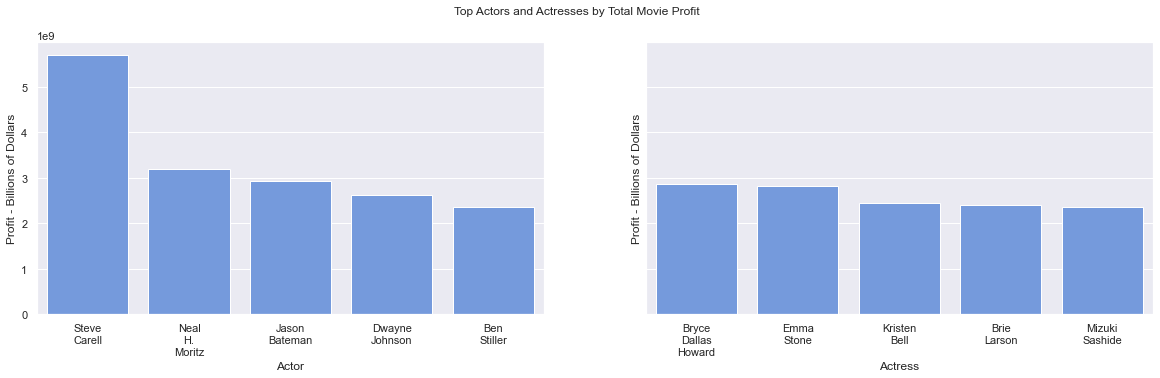

In [7]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,5),sharey=True)
fig.suptitle('Top Actors and Actresses by Total Movie Profit')

sns.barplot(ax=axes[0],x=actor_group_sum.index,y='profit',data=actor_group_sum,color='cornflowerblue')
axes[0].set(xlabel='Actor',ylabel='Profit - Billions of Dollars',title=' ')

sns.barplot(ax=axes[1],x=actress_group_sum.index,y='profit',data=actress_group_sum,color='cornflowerblue')
axes[1].set(xlabel='Actress',ylabel='Profit - Billions of Dollars',title=' ');
sns.set_context("poster", font_scale=0.8)

In [8]:
#find all the rows where the profession is actor
actor_group_median = tcombo_profession_profit.loc[tcombo_profession_profit['primary_profession'] == 'actor']
actor_group_median = actor_group_median.groupby(['primary_name']).median().sort_values(by='profit',ascending=False)[:5]
#find all the rows where the proffession is actress
actress_group_median = tcombo_profession_profit.loc[tcombo_profession_profit['primary_profession'] == 'actress']
actress_group_median = actress_group_median.groupby(['primary_name']).median().sort_values(by='profit',ascending=False)[:5]

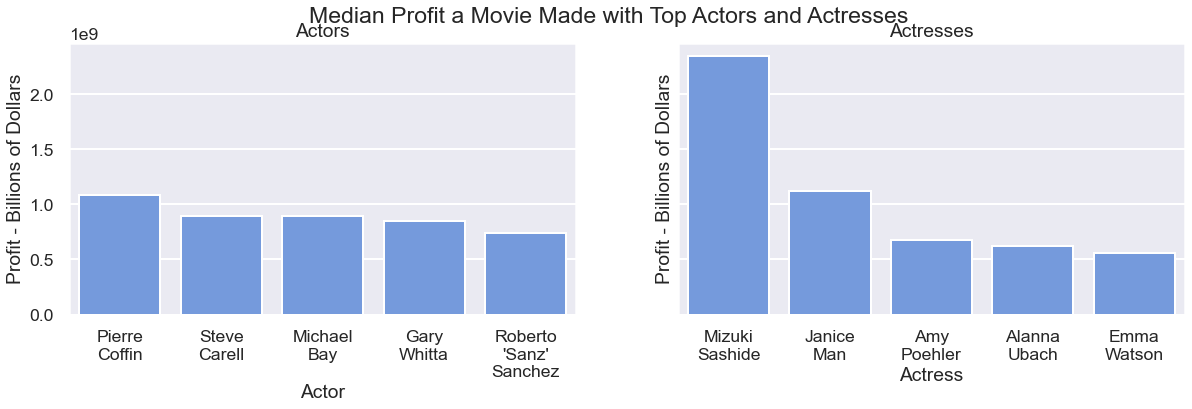

In [9]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,5),sharey=True)
fig.suptitle('Median Profit a Movie Made with Top Actors and Actresses')

sns.barplot(ax=axes[0],x=actor_group_median.index,y='profit',data=actor_group_median,color='cornflowerblue')
axes[0].set(xlabel='Actor',ylabel='Profit - Billions of Dollars',title='Actors')

sns.barplot(ax=axes[1],x=actress_group_median.index,y='profit',data=actress_group_median,color='cornflowerblue')
axes[1].set(xlabel='Actress',ylabel='Profit - Billions of Dollars',title='Actresses');